# Maze Roller --> Step FINAL

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy as sp
import scipy.linalg as linalg
sp.init_printing(use_latex='mathjax')

In [3]:
def ReadData(NameDerMessreihe, tstart=0, tend=None, info=False):
    lines = open('%s_daten.csv'%NameDerMessreihe, 'r').readlines()
    del lines[-1]
    del lines[0]
    open('%s_daten.csv'%NameDerMessreihe, 'w').writelines(lines) 
    
    src=open('%s_daten.csv'%NameDerMessreihe,"r")
    fline="time,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,GyroX2,GyroY2,GyroZ2,AccX2,AccY2,AccZ2\n"    #Prepending string
    oline=src.readlines()
    oline.insert(0,fline)
    src.close()
    src=open('%s_daten.csv'%NameDerMessreihe,"w")
    src.writelines(oline)
    src.close()
    
    data = pd.read_csv('%s_daten.csv'%NameDerMessreihe)
    data.time /= 1000                        #Umwandlung in Sekunden
    data.time -= data.time[0]                #Erste Messung auf t=0s setzen
    data = data[data.time>=tstart]
    if tend is not None:
        data = data[data.time<=tend]

    
    if info:
        with open('%s_beschreibung.txt'%NameDerMessreihe, encoding='utf-8') as fd:
            print(fd.read())
            
        display(data.head(5))
#        display(data.tail(3))
    return data
#data = ReadData(fileName, info=True)

# Kalman-Filter (mit beiden Sensoren)
Unser Systemzustand x, wobei $\dot{\phi} $ die Ableitung vom Winkel darstellt:
$$     x =\left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \phi_{Offset_1}\\
       \phi_{Offset_2}
       \end{matrix}\right]
$$

Unsere Messwerte y: 
$$     y =\left[\begin{matrix}\phi_1 \\ \phi_2 \\ gyro1.x\\gyro2.x\\
       \end{matrix}\right]
$$

## Systemtransfer-Matrix
Die Control-Input B entfällt in folgendem durch fehlendem u(t):

$$     x_{n+1} = Ad_{x_n} + Gd_{z_n} $$

$$
       \left[\begin{matrix}\phi_{n+1}\\
       \dot{\phi_{n+1}}\\
       \end{matrix}\right] = \left[\begin{matrix} 1 & Ts & 0 & 0\\
       0 & 1 & 0 & 0\\
       0 & 0 & 1 & 0\\
       0 & 0 & 0 & 1\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \phi_{Offset} \\
       \end{matrix}\right]
$$

Für unseren Sensor gilt:
$$ \phi_{neu} = \phi_{alt} + \dot{\phi} \cdot Ts - \phi_{Offset} \cdot Ts $$


## Die Messmatrix C

$$ y = \dot{\phi} - \phi_{Offset}$$
$$ y = C \cdot x = \left[\begin{matrix} 1 & 0 & 0 \\1 & 0 & 0 \\ 0 & 1 & -1\\ 0 & 1 & -1\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \end{matrix}\right] $$ 


## Das Prozessrauschen

$$
\dot{\mathbf x}(t) = A\mathbf x(t) + B\mathbf u(t) + G \mathbf z(t)
$$
$$
\left[\begin{matrix}\dot{\phi}\\
       \ddot{\phi}\\
       \dot{\phi_{Offset_1}}\\
       \dot{\phi_{Offset_2}}\\
       \end{matrix}\right] = \left[\begin{matrix} 0 & 1 & 0 & 0 \\
       0 & 0 & 0 & 0\\
       0 & 0 & 0 & 0\\
       0 & 0 & 0 & 0\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \phi_{Offset_1}\\
       \phi_{Offset_2}\\
       \end{matrix}\right] + \left[\begin{matrix}0\\
       z_1\\
       z_2\\
       z_3\\
       \end{matrix}\right]
$$

Im folgenden wird $G$ gebildet:
$$
 G = \left[\begin{matrix}0\\
       z_1\\
       z_2\\
       z_3\\
       \end{matrix}\right] =  \left[\begin{matrix}0 & 0 & 0\\
       1 & 0 & 0\\
       0 & 1 & 0\\
       0 & 0 & 1\\
       \end{matrix}\right] \cdot \left[\begin{matrix}z_1\\
       z_2\\
       z_3\\
       \end{matrix}\right]
$$
Im folgenden wird $G_d$ gebildet:
$$
 G_d = \int\limits_{0}^{T_s} A_d \cdot G\, d\tau = 
 \int\limits_{0}^{T_s} \begin{bmatrix}1&Ts&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{bmatrix} \cdot  
 \left[\begin{matrix}0 & 0 & 0\\
       1 & 0 & 0\\
       0 & 1 & 0\\
       0 & 0 & 1\\
       \end{matrix}\right]  
 \, d\tau
 = \int\limits_{0}^{T_s} \begin{bmatrix}Ts&0&0\\1&0&0\\0&1&0\\0&0&1\end{bmatrix}\, d\tau
$$
$$
 G_d = \begin{bmatrix}1/2Ts^2&0&0\\Ts&0&0\\0&Ts&0\\0&0&Ts\end{bmatrix}\
$$

## Filter

In [4]:
#Diese Matrizen sind mit dem Zustandsmodell x = [phi, phidot] erstellt.
#Die Messungen sind y = [gyro1, gyro2]
#Somit ist "holt" sich C jeweils das gleiche phidot aus dem Zustand.
#Gd berücksichtigt nur noch einen Rauschterm für phidot und ist daher 2x1

Ts = 8.9e-3 #Das hier ist die Zeitbasis aus Ihren Daten

A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

Ad = np.eye(4) + Ts*A

C = np.matrix([[1, 0, 0, 0],
               [1, 0, 0, 0], 
               [0, 1, -1, 0],
               [0, 1, 0, -1]])

Gd = np.matrix([[0.5*Ts**2, 0, 0], 
                [Ts, 0, 0],
                [0, Ts, 0],
                [0, 0, Ts]])


fileName="beideAchsen"
data = ReadData(fileName, info=False)

In [9]:
data.time

0        0.000
1        0.008
2        0.017
3        0.025
4        0.034
5        0.043
6        0.051
7        0.060
8        0.068
9        0.078
10       0.086
11       0.094
12       0.103
13       0.111
14       0.120
15       0.129
16       0.137
17       0.146
18       0.154
19       0.164
20       0.172
21       0.181
22       0.189
23       0.198
24       0.207
25       0.215
26       0.224
27       0.232
28       0.241
29       0.250
         ...  
2868    25.571
2869    25.579
2870    25.588
2871    25.597
2872    25.606
2873    25.614
2874    25.623
2875    25.633
2876    25.641
2877    25.650
2878    25.658
2879    25.667
2880    25.676
2881    25.685
2882    25.694
2883    25.702
2884    25.711
2885    25.720
2886    25.729
2887    25.737
2888    25.746
2889    25.755
2890    25.764
2891    25.773
2892    25.781
2893    25.790
2894    25.798
2895    25.808
2896    25.817
2897    25.825
Name: time, dtype: float64

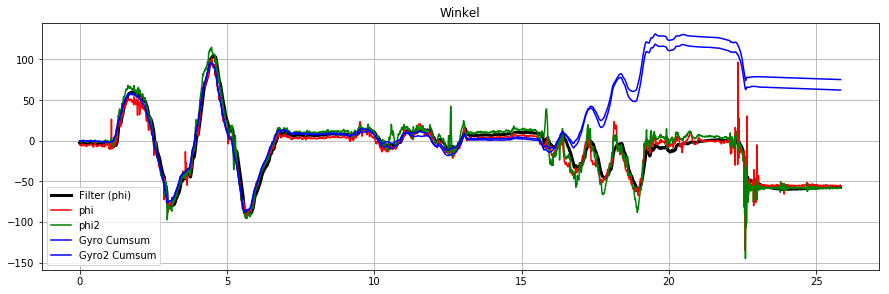

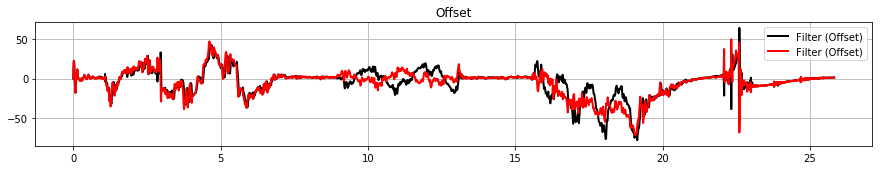

In [6]:
y_phi = np.arctan2(data.AccY, data.AccZ) / np.pi * 180
y_phi2 = np.arctan2(data.AccY2, data.AccZ2) / np.pi * 180
y_gyro = np.array(data.GyroX)
y_gyro2 = np.array(data.GyroX2)

y = np.concatenate( (y_phi[:,np.newaxis], y_phi2[:,np.newaxis], y_gyro[:,np.newaxis], y_gyro2[:,np.newaxis]), axis=1)

Q = np.diag([100, 10, 10])      #Prozessrauschen für die Ableitung von phidot
R = 1      # var(phix) , var(ygyro) [wird ignoriert, da in Q enthalten]

N = len(data.time)
x = list()
P = list()
K = list()

for n in range(N):
    yn = y[n:(n+1),:].T
    #yn = y[n]
    if n == 0:
        xlast = np.matrix([0,0,0,0]).T
        Plast = np.diag([1,1,1,1])*100
    else:
        xlast = x[n-1]
        Plast = P[n-1]
    
    x_priori = Ad * xlast
    P_priori = Ad * Plast * Ad.T + Gd * Q * Gd.T
    
    S = C * P_priori * C.T + R
    Kn = P_priori * C.T * linalg.pinv(S)
    x_post = x_priori + Kn*(yn - C*x_priori)
    P_post = (np.eye(4) - Kn*C)*P_priori
    
    x.append(x_post)
    P.append(P_post)
    K.append(Kn)

x = np.array(x).squeeze()
P = np.array(P).squeeze()
K = np.array(K).squeeze()

plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
ax.set_title('Winkel')
ax.plot(data.time, x[:,0], lw=3, color = 'k', label='Filter (phi)')
ax.plot(data.time, y[:,0], color='r',label='phi')
ax.plot(data.time, y[:,1], color='g',label='phi2')
ax.plot(data.time, y_gyro.cumsum()*Ts, color='b',label='Gyro Cumsum')
ax.plot(data.time, y_gyro2.cumsum()*Ts, color='b',label='Gyro2 Cumsum')
ax.grid()
ax.legend()

plt.figure(figsize=(15, 5))
ax = plt.subplot(212)
ax.set_title('Offset')
ax.plot(data.time, x[:,2], lw=2, color = 'k', label='Filter (Offset)')
ax.plot(data.time, x[:,3], lw=2, color = 'r', label='Filter (Offset)')
ax.legend()
ax.grid()

## Filter für anderen Winkel

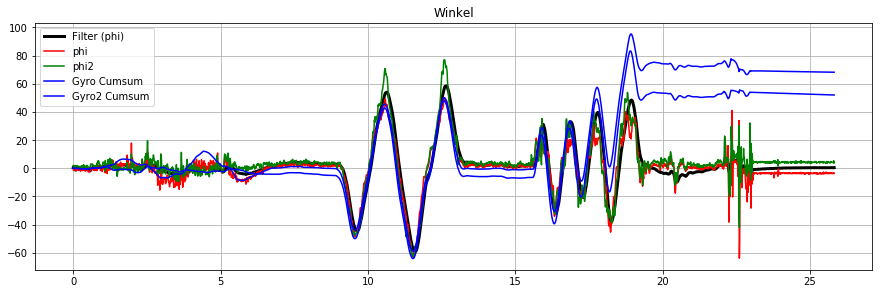

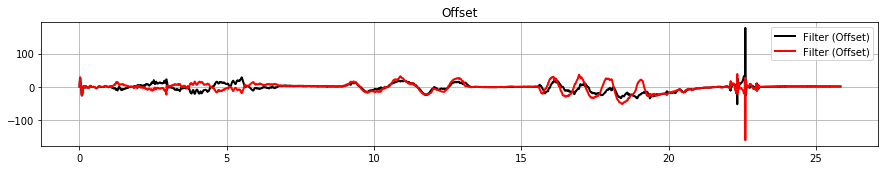

In [7]:
y_phi = np.arctan2(-data.AccX, (np.sqrt(data.AccY**2+data.AccZ**2))) / np.pi * 180
y_phi2 = np.arctan2(-data.AccX2, (np.sqrt(data.AccY2**2+data.AccZ2**2))) / np.pi * 180
y_gyro = np.array(data.GyroY)
y_gyro2 = np.array(data.GyroY2)

y = np.concatenate( (y_phi[:,np.newaxis], y_phi2[:,np.newaxis], y_gyro[:,np.newaxis], y_gyro2[:,np.newaxis]), axis=1)

Q = np.diag([100, 10, 10])      #Prozessrauschen für die Ableitung von phidot
R = 1      # var(phix) , var(ygyro) [wird ignoriert, da in Q enthalten]

N = len(data.time)
x = list()
P = list()
K = list()

for n in range(N):
    yn = y[n:(n+1),:].T
    #yn = y[n]
    if n == 0:
        xlast = np.matrix([0,0,0,0]).T
        Plast = np.diag([1,1,1,1])*100
    else:
        xlast = x[n-1]
        Plast = P[n-1]
    
    x_priori = Ad * xlast
    P_priori = Ad * Plast * Ad.T + Gd * Q * Gd.T
    
    S = C * P_priori * C.T + R
    Kn = P_priori * C.T * linalg.pinv(S)
    x_post = x_priori + Kn*(yn - C*x_priori)
    P_post = (np.eye(4) - Kn*C)*P_priori
    
    x.append(x_post)
    P.append(P_post)
    K.append(Kn)

x = np.array(x).squeeze()
P = np.array(P).squeeze()
K = np.array(K).squeeze()

plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
ax.set_title('Winkel')
ax.plot(data.time, x[:,0], lw=3, color = 'k', label='Filter (phi)')
ax.plot(data.time, y[:,0], color='r',label='phi')
ax.plot(data.time, y[:,1], color='g',label='phi2')
ax.plot(data.time, y_gyro.cumsum()*Ts, color='b',label='Gyro Cumsum')
ax.plot(data.time, y_gyro2.cumsum()*Ts, color='b',label='Gyro2 Cumsum')
ax.grid()
ax.legend()

plt.figure(figsize=(15, 5))
ax = plt.subplot(212)
ax.set_title('Offset')
ax.plot(data.time, x[:,2], lw=2, color = 'k', label='Filter (Offset)')
ax.plot(data.time, x[:,3], lw=2, color = 'r', label='Filter (Offset)')
ax.legend()
ax.grid()

In [8]:
x

array([[ 4.49252160e-01, -1.03810709e+00,  6.05676570e-03,
         1.03605677e+00],
       [ 4.08256049e-01,  9.54586438e+00,  1.12562535e+01,
         1.18262535e+01],
       [ 6.81546811e-01,  2.36726431e+01,  2.57099065e+01,
         2.65799065e+01],
       ...,
       [ 4.04384322e-01, -4.52643214e-01,  4.18539040e-01,
         9.08539040e-01],
       [ 3.38623731e-01,  4.58703926e-01,  3.63357633e-01,
         7.03357633e-01],
       [ 3.68383034e-01,  3.75827925e-02,  4.06348640e-01,
         7.76348640e-01]])